In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.style as style
style.use('ggplot') # Emulates "ggplot" in R

import sys

import warnings
warnings.filterwarnings('ignore')

In [11]:
def preds_as_series(data, preds):
    '''
    Helper function for plotting predictions.
    Converts a numpy array of predictions to a 
    pandas.DataFrame with datetimeindex
    
    Parameters
    -----
    preds - numpy.array, vector of predictions
    start - start date of the time series
    freq - the frequency of the time series e.g 'MS' or 'D'
    '''
    start = pd.date_range(start=data.index.max(), periods=2, freq=data.index.freq).max()
    idx = pd.date_range(start=start, periods=len(preds), freq=data.index.freq)
    return pd.DataFrame(preds, index=idx)

In [39]:
# Import data
# Load data
# data = pd.read_csv('data.csv')
data = pd.read_csv('data\planning_historic_actuals.csv')
data_52wks = data[data['MeasureID'] == 1013]

# Unpivot data
data_52wks = pd.melt(data_52wks, id_vars=data_52wks.columns[1:7], value_vars=data_52wks.columns[8:])

# Rename month column, filter error months, and set data type to date
data_52wks.rename(columns={'variable': 'date'}, inplace=True)
data_52wks = data_52wks.loc[data_52wks['date'].str.len() == 6]
data_52wks['date'] = pd.to_datetime(data_52wks['date'], format='%b-%y')

# Sum value to region total
data_52wks_forecast = data_52wks.groupby('date')['value'].sum().reset_index()

# Remove 'zero' data
data_52wks_forecast = data_52wks_forecast[data_52wks_forecast['value'] != 0]

# Set date as index
data_52wks_forecast = data_52wks_forecast.set_index('date')

data_52wks_forecast.index.freq = 'MS' # Set frequency to month (start)

data_52wks_forecast.head()


,value
date,
2023-05-01,370413.0
2023-06-01,369438.0
2023-07-01,376646.0
2023-08-01,383713.0
2023-09-01,378330.0


In [40]:
data_52wks_forecast.shape

(20, 1)

In [41]:
data_52wks_forecast.index.min()

Timestamp('2023-05-01 00:00:00', freq='MS')

In [42]:
data_52wks_forecast.index.max()

Timestamp('2024-12-01 00:00:00', freq='MS')

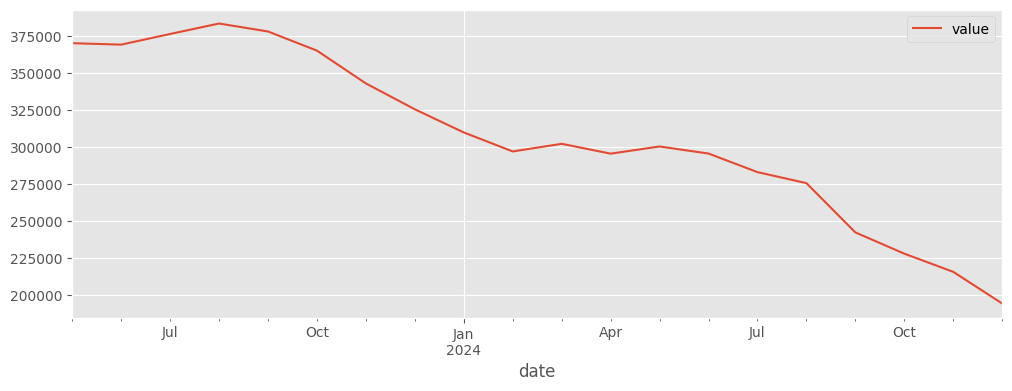

In [43]:
# Visualise data
_ = data_52wks_forecast.plot(figsize=(12,4))

In [48]:
# Import naive model
from forecast_tools.baseline import Naive1

In [ ]:
nf1 = Naive1()
nf1.fit(data_52wks_forecast)
nf1_preds = nf1.predict(horizon=12)

In [49]:
# Look at data
nf1_preds

array([194364., 194364., 194364., 194364., 194364., 194364., 194364.,
       194364., 194364., 194364., 194364., 194364., 194364., 194364.,
       194364., 194364., 194364., 194364., 194364., 194364., 194364.,
       194364., 194364., 194364., 194364., 194364., 194364., 194364.])

AttributeError: 'Legend' object has no attribute 'legendHandles'

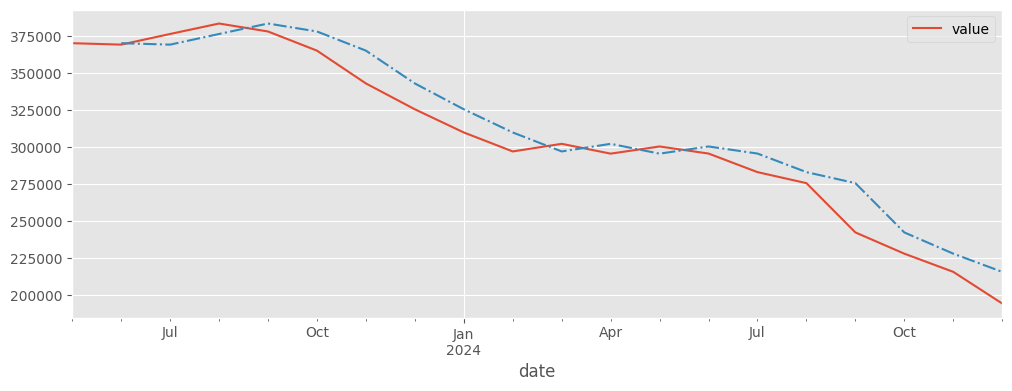

In [51]:
ax = data_52wks_forecast.plot(figsize=(12,4))
nf1.fittedvalues.plot(ax=ax, linestyle='-.') # same data, just shifted across by 1 day
preds_as_series(data_52wks_forecast, nf1_preds).plot(ax=ax)
_ = ax.legend(['train', 'Naive1'])

Add prediction confidence intervals

In [30]:
snf = SNaive(period=7)
snf.fit(data_52wks_forecast)
y_preds, y_intervals = snf.predict(horizon=6, return_predict_int=True, 
                                    alpha=[0.2, 0.05])
y_intervals # array of arrays

[array([[208066.1591898, 383487.8408102],
        [195509.1591898, 370930.8408102],
        [188061.1591898, 363482.8408102],
        [154735.1591898, 330156.8408102],
        [140372.1591898, 315793.8408102],
        [128065.1591898, 303486.8408102]]),
 array([[161634.84476908, 429919.15523092],
        [149077.84476908, 417362.15523092],
        [141629.84476908, 409914.15523092],
        [108303.84476908, 376588.15523092],
        [ 93940.84476908, 362225.15523092],
        [ 81633.84476908, 349918.15523092]])]

In [31]:
y_intervals[0] # 80% Intervals

array([[208066.1591898, 383487.8408102],
       [195509.1591898, 370930.8408102],
       [188061.1591898, 363482.8408102],
       [154735.1591898, 330156.8408102],
       [140372.1591898, 315793.8408102],
       [128065.1591898, 303486.8408102]])

In [32]:
y_intervals[1] # 95% Intervals

array([[161634.84476908, 429919.15523092],
       [149077.84476908, 417362.15523092],
       [141629.84476908, 409914.15523092],
       [108303.84476908, 376588.15523092],
       [ 93940.84476908, 362225.15523092],
       [ 81633.84476908, 349918.15523092]])

In [33]:
def plot_prediction_intervals(train, preds, intervals, test=None):
    '''
    Helper function to plot training data, point preds
    and 2 sets of prediction intevals
    
    assume 2 sets of PIs are provided!
    
    Params
    ------
    train : pd.DataFrame
        Training data
        
    preds : np.ndarray
        Predictions
        
    intervals : list
        List of arrays of intervals
        
    test : pd.DataFrame
        Test data

    '''
    ax = train.plot(figsize=(12,4))

    mean = preds_as_series(train, preds)
    intervals_80 = preds_as_series(train, intervals[0])
    intervals_90 = preds_as_series(train, intervals[1])

    mean.plot(ax=ax, label='point forecast')

    ax.fill_between(intervals_80.index, mean[0], intervals_80[1], 
                    alpha=0.2,
                    label='80% PI', color='yellow');

    ax.fill_between(intervals_80.index,mean[0], intervals_80[0], 
                    alpha=0.2,
                    label='80% PI', color='yellow');

    ax.fill_between(intervals_80.index,intervals_80[1], intervals_90[1], 
                    alpha=0.2,
                    label='90% PI', color='purple');

    ax.fill_between(intervals_80.index,intervals_80[0], intervals_90[0], 
                    alpha=0.2,
                    label='90% PI', color='purple');
    
    if test is None:
        ax.legend(['train', 'point forecast', '80%PI', '_ignore','_ignore', 
                   '95%PI'], loc=2)
    else:
        test.plot(ax=ax, color='black')
        ax.legend(['train', 'point forecast', 'Test', '80%PI', '_ignore',
                   '_ignore', '90%PI'], loc=2)
    
    

AttributeError: 'Legend' object has no attribute 'legendHandles'

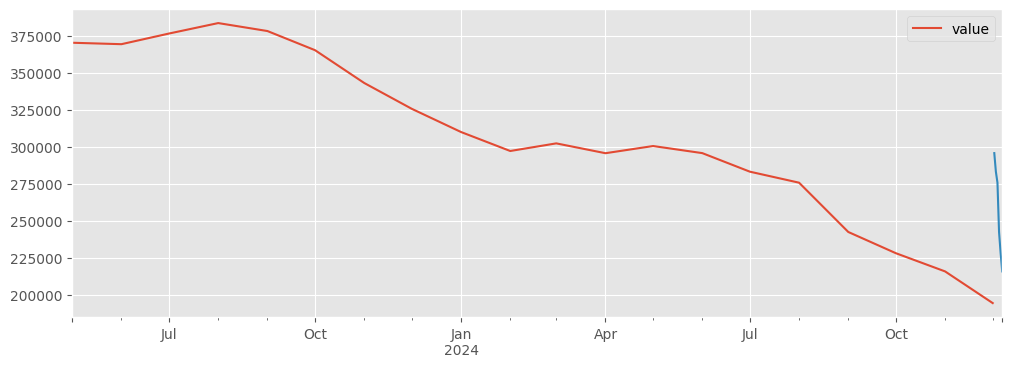

In [34]:
plot_prediction_intervals(data_52wks_forecast, y_preds, y_intervals)